# Analyze the characteristics of datasets generated using RealCause

This notebook analyzes the characteristics of the datasets that have been generated using RealCause. This is similar to the analysis that we performed for Credence. It uses the same OSAPO dataset (ACIC_4) with a specific linear biasing function. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Import the necessary libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
import random

# Import the function to load the original data
import os
os.chdir('/work/pi_jensen_umass_edu/pboddavarama_umass_edu/nfl/realcause')
from data.apo import get_apo_data

## Source dataset: Overlap = 0.5 (Weight = 1, Intercept = 0)

First, we will plot the marginal distributions of the source dataset. 

In [3]:
source_df = get_apo_data(identifier='acic', data_format='pandas', weight=1, intercept=0)

Information: {'post_treatment_vars': ['outcome'], 'treatment_var': ['treatment'], 'numerical_vars': ['outcome', 'x_29', 'x_1', 'x_5', 'x_6', 'x_18', 'x_19', 'x_20', 'x_23', 'x_25', 'x_26', 'x_27', 'x_28', 'x_34', 'x_35', 'x_36', 'x_37', 'x_43', 'x_44', 'x_45', 'x_57', 'x_58'], 'categorical_vars': ['treatment', 'x_3_leq_0', 'x_4_leq_0', 'x_7_leq_0', 'x_8_leq_0', 'x_9_leq_0', 'x_10_leq_0', 'x_11_leq_0', 'x_12_leq_0', 'x_13_leq_0', 'x_14_leq_0', 'x_15_leq_0', 'x_16_leq_0', 'x_17_leq_0', 'x_22_leq_0', 'x_24_B', 'x_24_C', 'x_24_D', 'x_24_E', 'x_30_leq_0', 'x_31_leq_0', 'x_32_leq_0', 'x_33_leq_0', 'x_38_leq_0', 'x_39_leq_6', 'x_40_leq_8', 'x_41_leq_1', 'x_42_leq_0', 'x_46_leq_0', 'x_47_leq_0', 'x_48_leq_0', 'x_49_leq_0', 'x_50_leq_0', 'x_51_leq_0', 'x_52_leq_0', 'x_53_leq_0', 'x_54_leq_0', 'x_55_leq_0', 'x_56_leq_0'], 'true_ate': 3.601669083381716, 'naive_ate': 5.149917010934845, 'biasing_vars': ['x_29']}


/work/pi_jensen_umass_edu/pboddavarama_umass_edu/nfl/realcause/data/apo.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  osapo_df['ites'] = osapo_df['counterfactual_outcome_1'] - osapo_df[
/work/pi_jensen_umass_edu/pboddavarama_umass_edu/.conda/envs/realcause-exact/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [4]:
# Create the source dataframe which is a combination of all these covariates
source_data = source_df['w']
source_data['treatment'] = source_df['t']
source_data['outcome'] = source_df['y']

Text(0.5, 1.0, 'Correlation between treatment and biasing covariate')

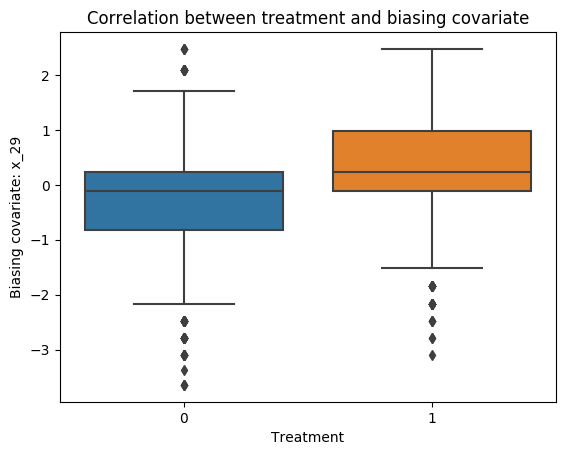

In [5]:
# Let us plot the correlation between a categorical variable and a continuous variable
# The categorical variable is 'treatment' and the continuous variable is 'x_29'
sns.boxplot(x='treatment', y='x_29', data=source_data)
plt.xlabel('Treatment')
plt.ylabel('Biasing covariate: x_29')
plt.title('Correlation between treatment and biasing covariate')

Text(0.5, 1.0, 'Correlation between treatment and non-biasing covariate')

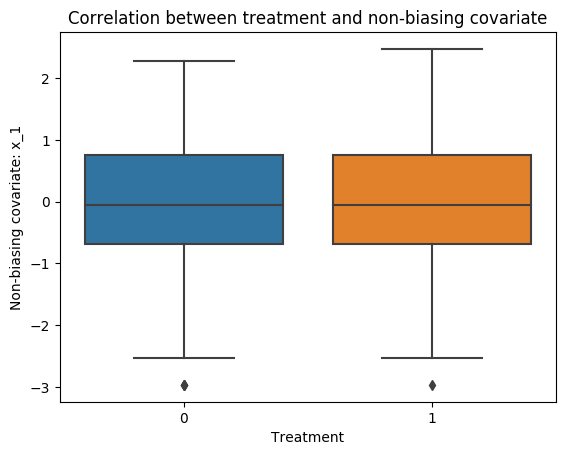

In [6]:
# To do a sanity check, we also pick one continous variable that is present in source_df_info['continuous_vars'] that is not the 'outcome' column, and plot the correlation between the treatment and this variable
sns.boxplot(x='treatment', y='x_1', data=source_data)
plt.xlabel('Treatment')
plt.ylabel('Non-biasing covariate: x_1')
plt.title('Correlation between treatment and non-biasing covariate')

Text(0.5, 1.0, 'Distribution of outcome variable for the two treatment groups')

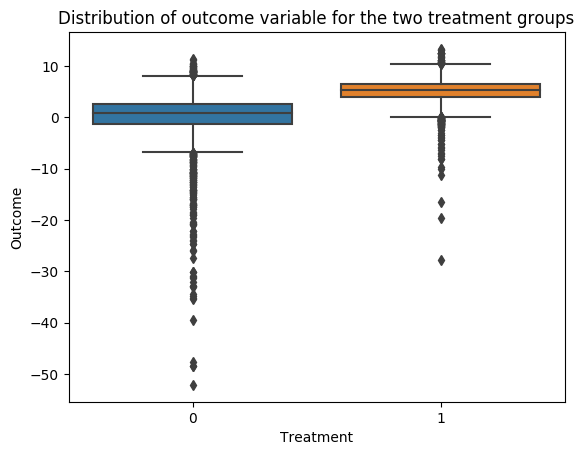

In [7]:
# Now, let us plot the distribution of the outcome variable for the two treatment groups
sns.boxplot(x='treatment', y='outcome', data=source_data)
plt.xlabel('Treatment')
plt.ylabel('Outcome')
plt.title('Distribution of outcome variable for the two treatment groups')

Text(0.5, 1.0, 'KDE plot of outcome variable for the two treatment groups')

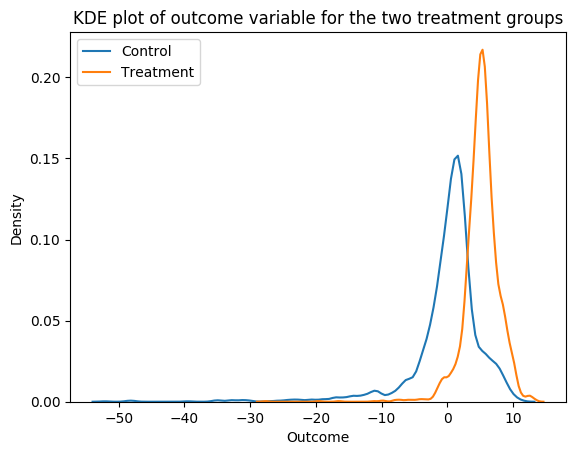

In [8]:
# Let us plot a KDE plot for the outcome variable for the two treatment groups
sns.kdeplot(source_data[source_data['treatment'] == 0]['outcome'], label='Control')
sns.kdeplot(source_data[source_data['treatment'] == 1]['outcome'], label='Treatment')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.legend()
plt.title('KDE plot of outcome variable for the two treatment groups')

Text(0.5, 1.0, 'ITEs for the source dataset')

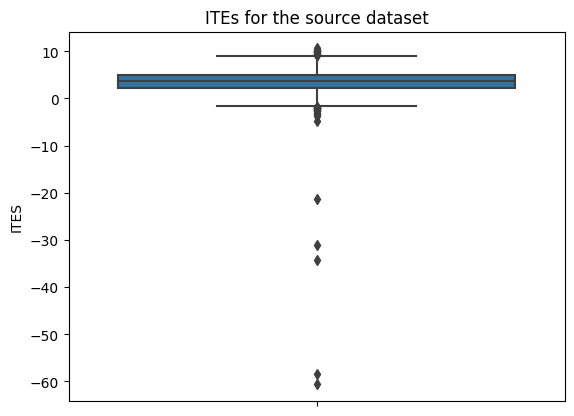

In [9]:
# Create a boxplot of the ITEs for the source data
sns.boxplot(y='ites', data=source_df)
plt.ylabel('ITES')
plt.title('ITEs for the source dataset')

There is some degree of heterogeneity in the treatment effect that we have observed.

Text(0.5, 1.0, 'Density plot of the ITEs')

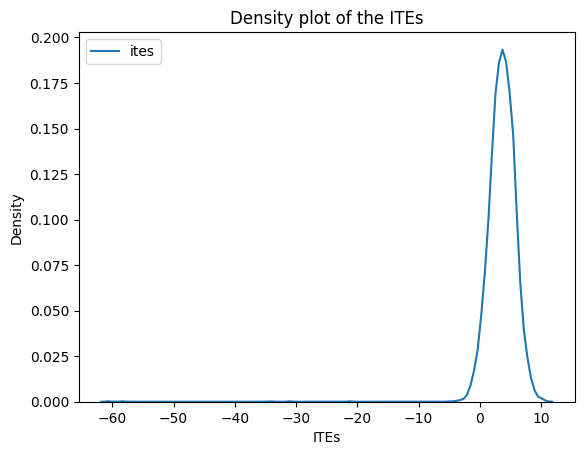

In [10]:
sns.kdeplot(source_df['ites'])
plt.xlabel('ITEs')
plt.ylabel('Density')
plt.title('Density plot of the ITEs')

## Effect: Identifiable, Overlap = 0.5, Biasing covariate = 1

We explore what is the distribution of the average treatment effects when we generate data using realcause without specifying any values for the knobs. 

In [11]:
GEN_DATASETS_DF = 'nfl_datasets/osapo_acic_4_weight_1_intercept_0/'
# Read in each of the generated datasets, compute the true ATE, naive ATE, and the distribution of ITEs and store them in a dataframe. 
gen_df_characteristics = pd.DataFrame(columns=['true_ate', 'naive_ate', 'ite_distribution']) 
for df_num in range(50): 
    # Read in the generated dataset
    gen_df = pd.read_csv(GEN_DATASETS_DF + 'dataset_' + str(df_num) + '.csv', index_col=0)
    # Create the outcome column
    gen_df['outcome'] = gen_df['t']*gen_df['y1'] + (1-gen_df['t'])*gen_df['y0']
    # Compute the true ATE
    true_ate = (gen_df['y1'] - gen_df['y0']).mean()
    # Compute the naive ATE 
    naive_ate = gen_df.loc[gen_df['t']==1,'outcome'].mean() - gen_df.loc[gen_df['t']==0,'outcome'].mean()
    # Get the ITE as a column 
    ites = np.array(gen_df['y1'] - gen_df['y0'])
    # Add them to the gen_df_characteristics dataframe
    gen_df_characteristics.loc[df_num] = [true_ate, naive_ate, ites]

In [12]:
gen_df_characteristics.head()

,true_ate,naive_ate,ite_distribution
0,3.950031,5.459664,"[5.285621699999999, 7.275459300000001, 2.78824..."
1,3.931280,5.545872,"[6.573444350000001, 7.425247199999999, 1.06580..."
2,3.911861,5.395143,"[3.78998562, 3.4674034000000002, 4.2415353, 6...."
3,3.920843,5.465932,"[5.530948660000001, 6.90949622, 3.072467999999..."
4,3.962707,5.431929,"[4.84446736, 3.8411674000000007, 1.74197799999..."


Text(0.5, 1.0, 'Distribution of the true ATE for the generated datasets')

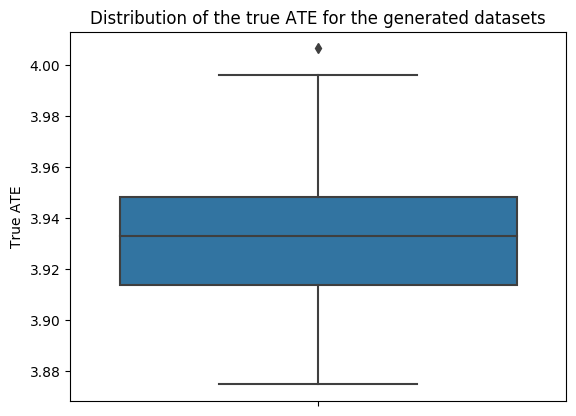

In [13]:
# Plot the distribution of the true ATEs
sns.boxplot(y='true_ate', data=gen_df_characteristics)
plt.ylabel('True ATE')
plt.title('Distribution of the true ATE for the generated datasets')

Text(0.5, 1.0, 'Distribution of the naive ATE for the generated datasets')

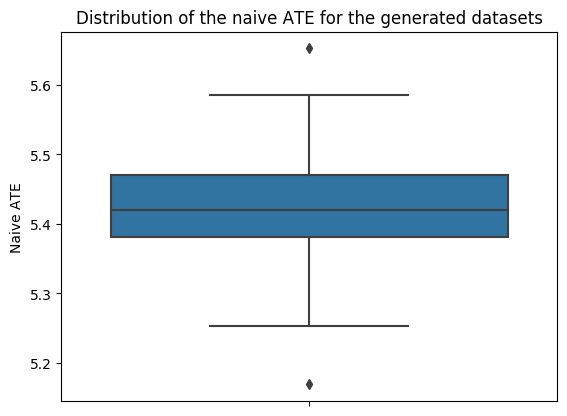

In [14]:
# Plot the distribution of the naive ATEs
sns.boxplot(y='naive_ate', data=gen_df_characteristics)
plt.ylabel('Naive ATE')
plt.title('Distribution of the naive ATE for the generated datasets')

Text(0.5, 1.0, 'Density plot of ITE for the generated datasets (1-50)')

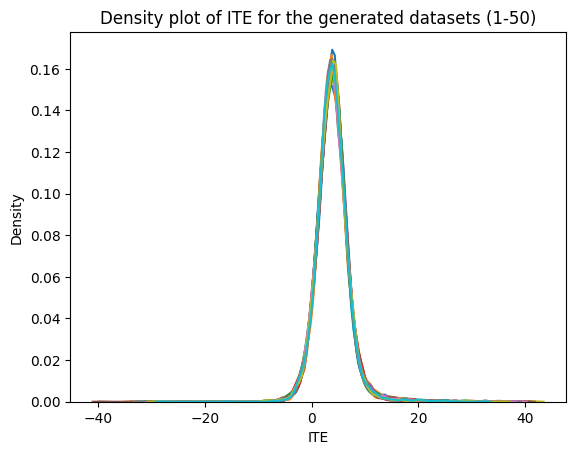

In [15]:
# Plot density plots of the ITEs for each row of the gen_df_characteristics dataframe
for i in range(50):
    sns.kdeplot(gen_df_characteristics.loc[i]['ite_distribution'])
plt.xlabel('ITE')
plt.ylabel('Density')
plt.title('Density plot of ITE for the generated datasets (1-50)')

Text(0.5, 1.0, 'KDE plot of outcome variable for the two \n treatment groups for Realcause vs. source dataset')

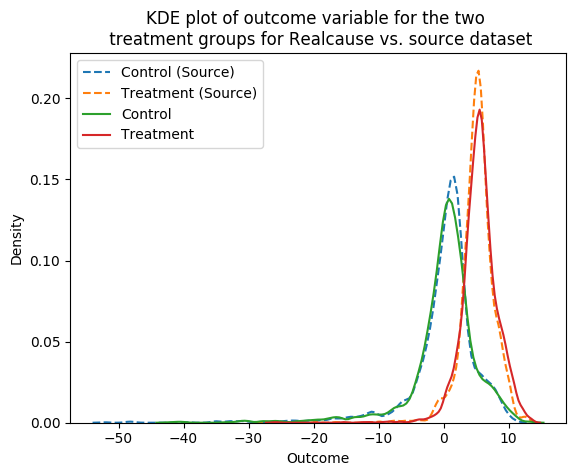

In [16]:
# Overlay the density plot of the source_df with the above plot
sns.kdeplot(source_data[source_data['treatment'] == 0]['outcome'], label='Control (Source)', linestyle='--')
sns.kdeplot(source_data[source_data['treatment'] == 1]['outcome'], label='Treatment (Source)', linestyle='--')
sns.kdeplot(gen_df[gen_df['t']== 0]['outcome'], label='Control')
sns.kdeplot(gen_df[gen_df['t'] == 1]['outcome'], label='Treatment')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.legend()
plt.title('KDE plot of outcome variable for the two \n treatment groups for Realcause vs. source dataset')

In [17]:
# For gen_df, compute the proportion of treated samples
gen_df['t'].value_counts(normalize=True)

0.0    0.526239
1.0    0.473761
Name: t, dtype: float64

## Effect: Identifiable effect, Weight: 2.5, Intercept -2 

First we change the source dataset to see what the overlap looks like. 

In [18]:
source_df = get_apo_data(identifier='acic', data_format='pandas', weight=2.5, intercept=-2)
source_data = source_df['w']
source_data['treatment'] = source_df['t']
source_data['outcome'] = source_df['y']
source_data['treatment'].value_counts(normalize=True)

Information: {'post_treatment_vars': ['outcome'], 'treatment_var': ['treatment'], 'numerical_vars': ['outcome', 'x_29', 'x_1', 'x_5', 'x_6', 'x_18', 'x_19', 'x_20', 'x_23', 'x_25', 'x_26', 'x_27', 'x_28', 'x_34', 'x_35', 'x_36', 'x_37', 'x_43', 'x_44', 'x_45', 'x_57', 'x_58'], 'categorical_vars': ['treatment', 'x_3_leq_0', 'x_4_leq_0', 'x_7_leq_0', 'x_8_leq_0', 'x_9_leq_0', 'x_10_leq_0', 'x_11_leq_0', 'x_12_leq_0', 'x_13_leq_0', 'x_14_leq_0', 'x_15_leq_0', 'x_16_leq_0', 'x_17_leq_0', 'x_22_leq_0', 'x_24_B', 'x_24_C', 'x_24_D', 'x_24_E', 'x_30_leq_0', 'x_31_leq_0', 'x_32_leq_0', 'x_33_leq_0', 'x_38_leq_0', 'x_39_leq_6', 'x_40_leq_8', 'x_41_leq_1', 'x_42_leq_0', 'x_46_leq_0', 'x_47_leq_0', 'x_48_leq_0', 'x_49_leq_0', 'x_50_leq_0', 'x_51_leq_0', 'x_52_leq_0', 'x_53_leq_0', 'x_54_leq_0', 'x_55_leq_0', 'x_56_leq_0'], 'true_ate': 3.601669083381716, 'naive_ate': 5.191977988337404, 'biasing_vars': ['x_29']}


/work/pi_jensen_umass_edu/pboddavarama_umass_edu/nfl/realcause/data/apo.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  osapo_df['ites'] = osapo_df['counterfactual_outcome_1'] - osapo_df[
/work/pi_jensen_umass_edu/pboddavarama_umass_edu/.conda/envs/realcause-exact/lib/python3.8/site-packages/pandas/core/frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


0    0.771345
1    0.228655
Name: treatment, dtype: float64

In [19]:
GEN_DATASETS_DF = 'nfl_datasets/osapo_acic_4_weight_2.5_intercept_-2/'
# Read in each of the generated datasets, compute the true ATE, naive ATE, and the distribution of ITEs and store them in a dataframe. 
gen_df_characteristics = pd.DataFrame(columns=['true_ate', 'naive_ate', 'ite_distribution']) 
for df_num in range(50): 
    # Read in the generated dataset
    gen_df = pd.read_csv(GEN_DATASETS_DF + 'dataset_' + str(df_num) + '.csv', index_col=0)
    # Create the outcome column
    gen_df['outcome'] = gen_df['t']*gen_df['y1'] + (1-gen_df['t'])*gen_df['y0']
    # Compute the true ATE
    true_ate = (gen_df['y1'] - gen_df['y0']).mean()
    # Compute the naive ATE 
    naive_ate = gen_df.loc[gen_df['t']==1,'outcome'].mean() - gen_df.loc[gen_df['t']==0,'outcome'].mean()
    # Get the ITE as a column 
    ites = np.array(gen_df['y1'] - gen_df['y0'])
    # Add them to the gen_df_characteristics dataframe
    gen_df_characteristics.loc[df_num] = [true_ate, naive_ate, ites]

In [20]:
gen_df_characteristics.head()

,true_ate,naive_ate,ite_distribution
0,4.509425,5.712300,"[3.9966049, 6.9018288000000005, 1.566307400000..."
1,4.487946,5.662376,"[5.4259070000000005, 7.5335732, -0.9004059, 5...."
2,4.477079,5.688431,"[2.2230453999999993, 3.0046005, 2.7152445, 6.8..."
3,4.496304,5.776163,"[4.6499481000000005, 7.837719, 1.5671540000000..."
4,4.521838,5.690666,"[3.5147207, 3.9020080200000002, 0.251652000000..."


In [21]:
# Find the proportion of treated samples in each of the generated datasets
df_num = random.randint(0, 49)
gen_df = pd.read_csv(GEN_DATASETS_DF + 'dataset_' + str(df_num) + '.csv', index_col=0)
print(gen_df['t'].value_counts(normalize=True))

0.0    0.762391
1.0    0.237609
Name: t, dtype: float64


Text(0.5, 1.0, 'Distribution of the true ATE for the generated datasets')

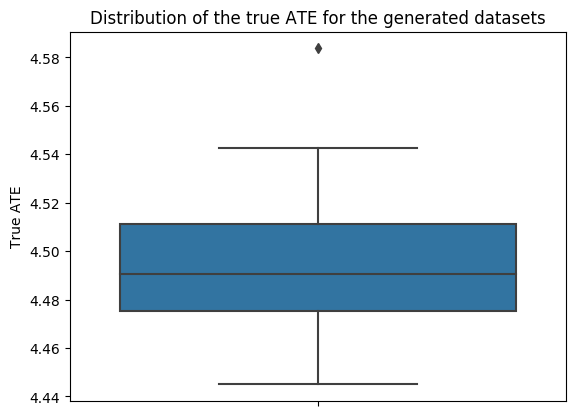

In [22]:
# Plot the distribution of the true ATEs
sns.boxplot(y='true_ate', data=gen_df_characteristics)
plt.ylabel('True ATE')
plt.title('Distribution of the true ATE for the generated datasets')

Text(0.5, 1.0, 'Distribution of the naive ATE for the generated datasets')

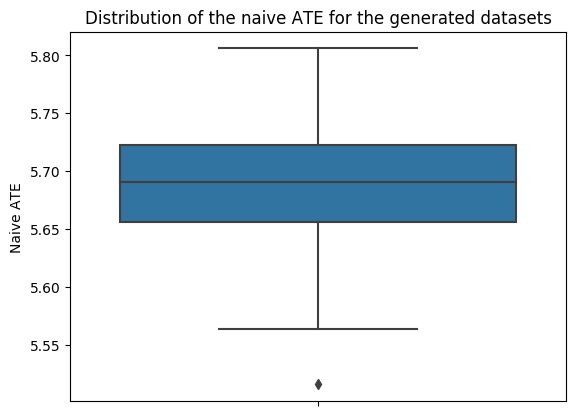

In [23]:
# Plot the distribution of the naive ATEs
sns.boxplot(y='naive_ate', data=gen_df_characteristics)
plt.ylabel('Naive ATE')
plt.title('Distribution of the naive ATE for the generated datasets')

Text(0.5, 1.0, 'Density plot of ITE for the generated datasets (1-50)')

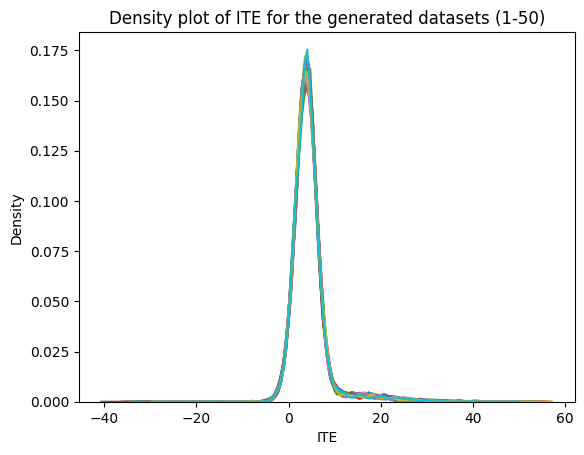

In [24]:
# Plot density plots of the ITEs for each row of the gen_df_characteristics dataframe
for i in range(50):
    sns.kdeplot(gen_df_characteristics.loc[i]['ite_distribution'])
plt.xlabel('ITE')
plt.ylabel('Density')
plt.title('Density plot of ITE for the generated datasets (1-50)')

Text(0.5, 1.0, 'KDE plot of outcome variable for the two \n treatment groups for Realcause vs. source dataset')

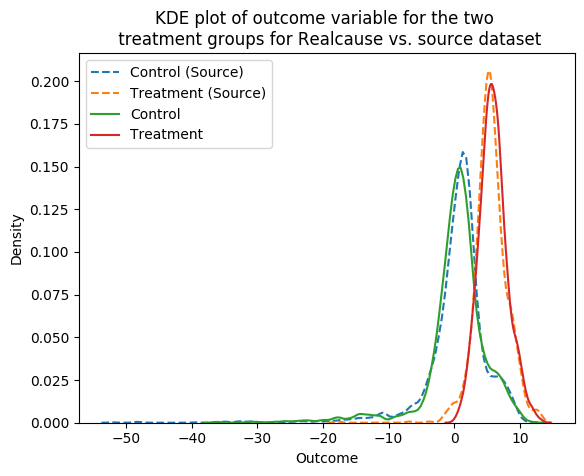

In [25]:
# Overlay the density plot of the source_df with the above plot
sns.kdeplot(source_data[source_data['treatment'] == 0]['outcome'], label='Control (Source)', linestyle='--')
sns.kdeplot(source_data[source_data['treatment'] == 1]['outcome'], label='Treatment (Source)', linestyle='--')
sns.kdeplot(gen_df[gen_df['t']== 0]['y'], label='Control')
sns.kdeplot(gen_df[gen_df['t'] == 1]['y'], label='Treatment')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.legend()
plt.title('KDE plot of outcome variable for the two \n treatment groups for Realcause vs. source dataset')

Text(0.5, 1.0, 'Distribution of the treatment variable for the source and generated datasets')

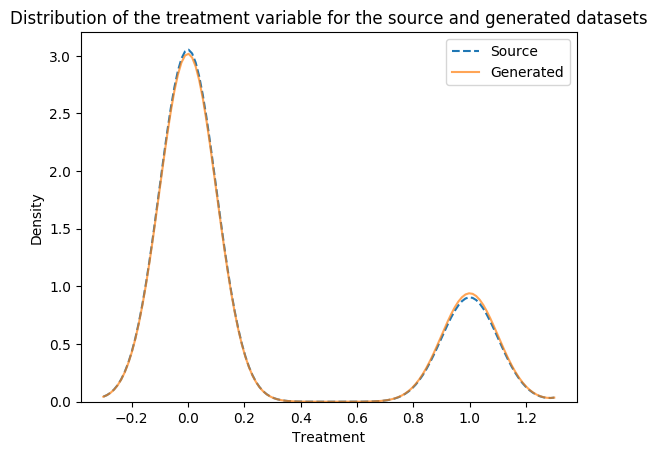

In [30]:
# Create a plot of the treatment column for the source data vs. gen_df
sns.kdeplot(source_data['treatment'], label='Source', linestyle='--', bw=0.1)
sns.kdeplot(gen_df['t'], label='Generated', bw=0.1, alpha=0.7)
plt.xlabel('Treatment')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of the treatment variable for the source and generated datasets')

In [36]:
og_source_df = get_apo_data(identifier='acic', data_format='pandas', ret_counterfactual_outcomes=True, weight=2.5, Intercept=-2)
og_source_df.columns

Information: {'post_treatment_vars': ['outcome'], 'treatment_var': ['treatment'], 'numerical_vars': ['outcome', 'x_29', 'x_1', 'x_5', 'x_6', 'x_18', 'x_19', 'x_20', 'x_23', 'x_25', 'x_26', 'x_27', 'x_28', 'x_34', 'x_35', 'x_36', 'x_37', 'x_43', 'x_44', 'x_45', 'x_57', 'x_58'], 'categorical_vars': ['treatment', 'x_3_leq_0', 'x_4_leq_0', 'x_7_leq_0', 'x_8_leq_0', 'x_9_leq_0', 'x_10_leq_0', 'x_11_leq_0', 'x_12_leq_0', 'x_13_leq_0', 'x_14_leq_0', 'x_15_leq_0', 'x_16_leq_0', 'x_17_leq_0', 'x_22_leq_0', 'x_24_B', 'x_24_C', 'x_24_D', 'x_24_E', 'x_30_leq_0', 'x_31_leq_0', 'x_32_leq_0', 'x_33_leq_0', 'x_38_leq_0', 'x_39_leq_6', 'x_40_leq_8', 'x_41_leq_1', 'x_42_leq_0', 'x_46_leq_0', 'x_47_leq_0', 'x_48_leq_0', 'x_49_leq_0', 'x_50_leq_0', 'x_51_leq_0', 'x_52_leq_0', 'x_53_leq_0', 'x_54_leq_0', 'x_55_leq_0', 'x_56_leq_0'], 'true_ate': 3.601669083381716, 'naive_ate': 5.785435385437475, 'biasing_vars': ['x_29']}


/work/pi_jensen_umass_edu/pboddavarama_umass_edu/nfl/realcause/data/apo.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  osapo_df['ites'] = osapo_df['counterfactual_outcome_1'] - osapo_df[


Index(['treatment', 'outcome', 'x_1', 'x_5', 'x_6', 'x_18', 'x_19', 'x_20',
       'x_23', 'x_25', 'x_26', 'x_27', 'x_28', 'x_29', 'x_34', 'x_35', 'x_36',
       'x_37', 'x_43', 'x_44', 'x_45', 'x_57', 'x_58',
       'counterfactual_outcome_1', 'counterfactual_outcome_0', 'x_3_leq_0',
       'x_4_leq_0', 'x_7_leq_0', 'x_8_leq_0', 'x_9_leq_0', 'x_10_leq_0',
       'x_11_leq_0', 'x_12_leq_0', 'x_13_leq_0', 'x_14_leq_0', 'x_15_leq_0',
       'x_16_leq_0', 'x_17_leq_0', 'x_22_leq_0', 'x_24_B', 'x_24_C', 'x_24_D',
       'x_24_E', 'x_30_leq_0', 'x_31_leq_0', 'x_32_leq_0', 'x_33_leq_0',
       'x_38_leq_0', 'x_39_leq_6', 'x_40_leq_8', 'x_41_leq_1', 'x_42_leq_0',
       'x_46_leq_0', 'x_47_leq_0', 'x_48_leq_0', 'x_49_leq_0', 'x_50_leq_0',
       'x_51_leq_0', 'x_52_leq_0', 'x_53_leq_0', 'x_54_leq_0', 'x_55_leq_0',
       'x_56_leq_0', 'ites'],
      dtype='object')

Randomly picked dataset number: 7


Text(0.5, 1.0, 'KDE plot of counterfactual outcomes for the generated datasets')

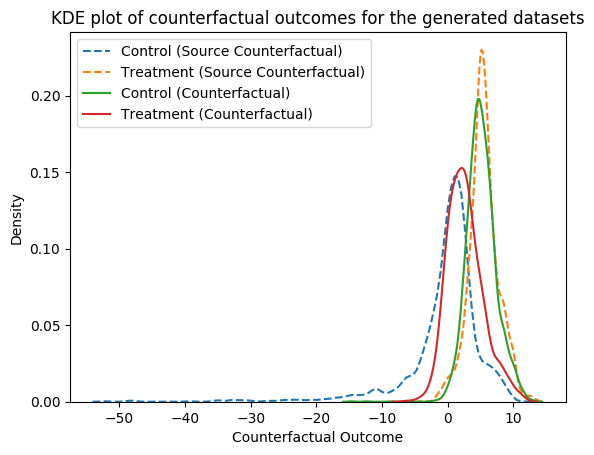

In [60]:
# Plot the counterfactual outcomes for the source data for any one of the gen_df
df_num = random.randint(0, 49)
print(f'Randomly picked dataset number: {df_num}')
gen_df = pd.read_csv(GEN_DATASETS_DF + 'dataset_' + str(df_num) + '.csv', index_col=0)
sns.kdeplot(og_source_df[og_source_df['treatment'] == 0]['counterfactual_outcome_0'], label='Control (Source Counterfactual)', linestyle='--')
sns.kdeplot(og_source_df[og_source_df['treatment'] == 1]['counterfactual_outcome_1'], label='Treatment (Source Counterfactual)', linestyle='--')
sns.kdeplot(gen_df[gen_df['t']== 0]['y1'], label='Control (Counterfactual)')
sns.kdeplot(gen_df[gen_df['t'] == 1]['y0'], label='Treatment (Counterfactual)')
plt.xlabel('Counterfactual Outcome')
plt.ylabel('Density')
plt.legend()
plt.title('KDE plot of counterfactual outcomes for the generated datasets')

## Effect: Identifiable, Weight = 2.5, Intercept = -4

In [27]:
GEN_DATASETS_DF = 'nfl_datasets/osapo_acic_4_weight_2.5_intercept_-4/'
# Read in each of the generated datasets, compute the true ATE, naive ATE, and the distribution of ITEs and store them in a dataframe.
gen_df_characteristics = pd.DataFrame(columns=['true_ate', 'naive_ate', 'ite_distribution'])
for df_num in range(50):
    # Read in the generated dataset
    gen_df = pd.read_csv(GEN_DATASETS_DF + 'dataset_' + str(df_num) + '.csv', index_col=0)
    # Create the outcome column
    gen_df['outcome'] = gen_df['t']*gen_df['y1'] + (1-gen_df['t'])*gen_df['y0']
    # Compute the true ATE
    true_ate = (gen_df['y1'] - gen_df['y0']).mean()
    # Compute the naive ATE
    naive_ate = gen_df.loc[gen_df['t']==1,'outcome'].mean() - gen_df.loc[gen_df['t']==0,'outcome'].mean()
    # Get the ITE as a column
    ites = np.array(gen_df['y1'] - gen_df['y0'])
    # Add them to the gen_df_characteristics dataframe
    gen_df_characteristics.loc[df_num] = [true_ate, naive_ate, ites]   

In [28]:
gen_df_characteristics.head()

,true_ate,naive_ate,ite_distribution
0,5.038756,5.195856,"[8.2767106, 6.6848030000000005, 6.035965050000..."
1,5.123551,5.170025,"[13.438667299999999, 6.8827667, 1.95311356, 11..."
2,4.950448,4.920986,"[4.356472, -1.2718923999999996, 9.8054197, 9.9..."
3,3.037391,3.437520,"[8.32492044, 6.8089183, 6.9534683, 2.7504349, ..."
4,5.113506,5.163002,"[6.9207917000000005, -0.05413829999999997, 4.0..."


In [29]:
# Find the proportion of treated samples in each of the generated datasets
for df_num in range(1):
    gen_df = pd.read_csv(GEN_DATASETS_DF + 'dataset_' + str(df_num) + '.csv', index_col=0)
    print(gen_df['t'].value_counts(normalize=True))

1.0    0.524573
0.0    0.475427
Name: t, dtype: float64


Text(0.5, 1.0, 'Distribution of the true ATE for the generated datasets')

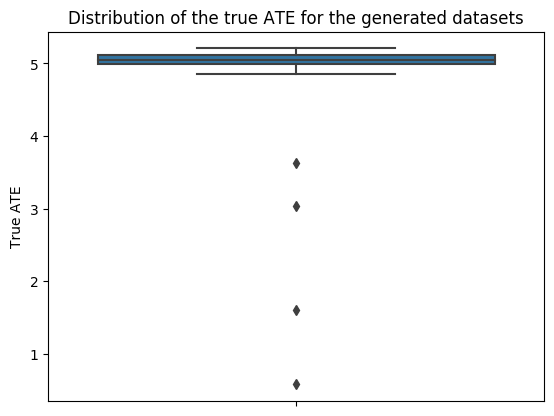

In [30]:
# Plot the distribution of the true ATEs
sns.boxplot(y='true_ate', data=gen_df_characteristics)
plt.ylabel('True ATE')
plt.title('Distribution of the true ATE for the generated datasets')

Text(0.5, 1.0, 'Distribution of the naive ATE for the generated datasets')

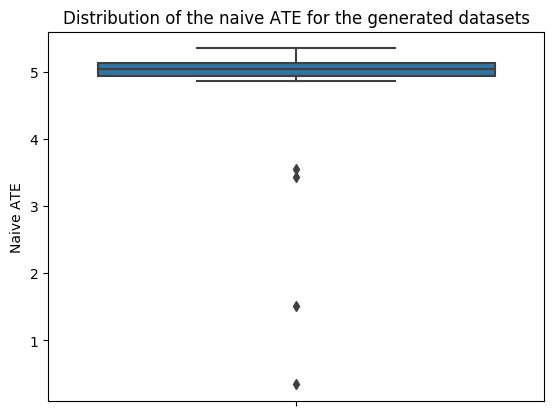

In [31]:
# Plot the distribution of the naive ATEs
sns.boxplot(y='naive_ate', data=gen_df_characteristics)
plt.ylabel('Naive ATE')
plt.title('Distribution of the naive ATE for the generated datasets')

Text(0.5, 1.0, 'Density plot of ITE for the generated datasets (1-50)')

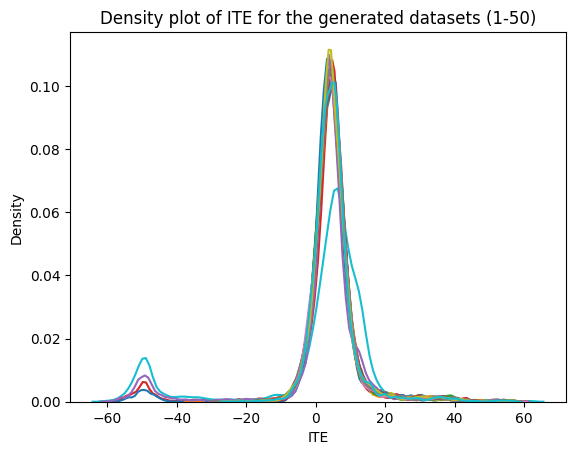

In [32]:
# Plot density plots of the ITEs for each row of the gen_df_characteristics dataframe
for i in range(50):
    sns.kdeplot(gen_df_characteristics.loc[i]['ite_distribution'])
plt.xlabel('ITE')
plt.ylabel('Density')
plt.title('Density plot of ITE for the generated datasets (1-50)')

Text(0.5, 1.0, 'KDE plot of outcome variable for the two \n treatment groups for Realcause vs. source dataset')

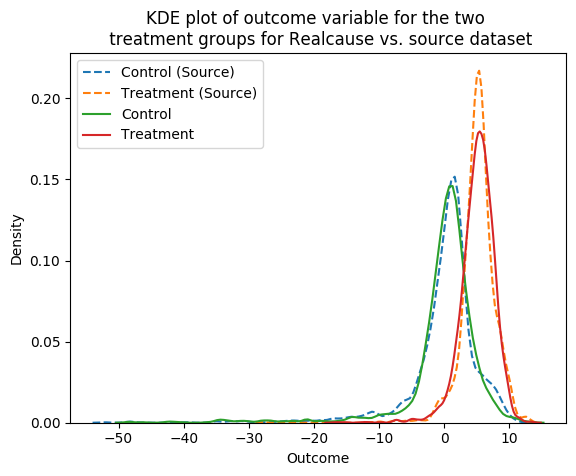

In [33]:
# Overlay the density plot of the source_df with the above plot
sns.kdeplot(source_data[source_data['treatment'] == 0]['outcome'], label='Control (Source)', linestyle='--')
sns.kdeplot(source_data[source_data['treatment'] == 1]['outcome'], label='Treatment (Source)', linestyle='--')
sns.kdeplot(gen_df[gen_df['t']== 0]['y'], label='Control')
sns.kdeplot(gen_df[gen_df['t'] == 1]['y'], label='Treatment')
plt.xlabel('Outcome')
plt.ylabel('Density')
plt.legend()
plt.title('KDE plot of outcome variable for the two \n treatment groups for Realcause vs. source dataset')

In [34]:
# For gen_df, compute the proportion of treated samples
gen_df['t'].value_counts(normalize=True)

1.0    0.524573
0.0    0.475427
Name: t, dtype: float64

Text(0.5, 1.0, 'Distribution of the treatment variable for the source and generated datasets')

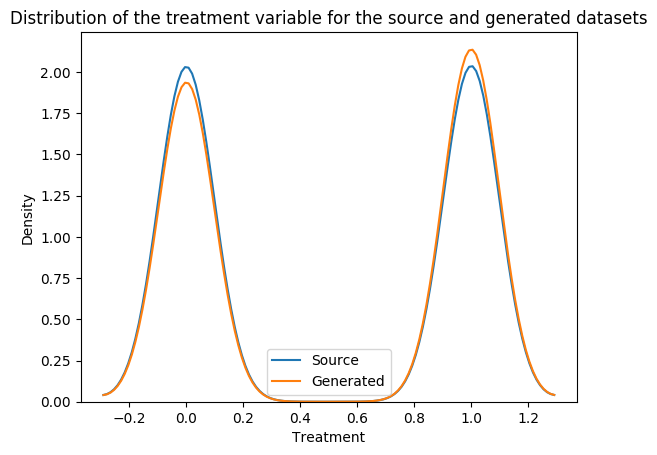

In [37]:
# Create a plot of the treatment column for the source data vs. gen_df
sns.kdeplot(source_data['treatment'], label='Source')
sns.kdeplot(gen_df['t'], label='Generated')
plt.xlabel('Treatment')
plt.ylabel('Density')
plt.legend()
plt.title('Distribution of the treatment variable for the source and generated datasets')